### We first need to define probabilistic orthonormal legendre polynomials for standard uniform as well as define the corresponding scalar product and triple product

In [58]:
import numpy as np
from scipy.special import legendre
from scipy.integrate import quad ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
from scipy.integrate import quad_vec ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
import matplotlib.pyplot as plt
np.random.seed(20)

In [59]:
# Define the orthonormal probabilistic Legendre polynomial
def orthonormal_legendre(n):
    return lambda x: legendre(n)(x) * np.sqrt(n+0.5)

# Define the integrand for scalar product
def scalar_int(i,j):
    return lambda x:orthonormal_legendre(i)(x) * orthonormal_legendre(j)(x)

# Define the integrand for triple product
def triple_int(i,j,k):
    return lambda x:orthonormal_legendre(i)(x) * orthonormal_legendre(j)(x)* orthonormal_legendre(k)(x)

# Integrate to verify orthonormality
integral1, _ = quad(scalar_int(2,2), -1, 1)
integral2, _ = quad(scalar_int(2,3), -1, 1)
print(f"The scalar product of the orthonormal probabilistic Legendre polynomials H_2(x) and H_2(x) is approximately {integral1}")
print(f"The scalar product of the orthonormal probabilistic Legendre polynomials H_2(x) and H_3(x) is approximately {integral2}")

The scalar product of the orthonormal probabilistic Legendre polynomials H_2(x) and H_2(x) is approximately 1.0000000000000002
The scalar product of the orthonormal probabilistic Legendre polynomials H_2(x) and H_3(x) is approximately -1.5189667548414296e-16


##### DEFINING THE KERNEL FUNCTIONS

In [60]:
## defining kernel derivative function

def W2(x, l):
    R = np.abs(x) / l
    a = 1 / l
    mask1 = R <= 1
    mask2 = np.logical_and(R > 1, R < 2)
    result = np.zeros_like(R)
    result[mask1] = (2/3 - R[mask1]**2 + 0.5 * R[mask1]**3) * a
    result[mask2] = ((2 - R[mask2])**3) / 6 * a
    return result

def kernel(x,h):
    rr=np.abs(x)
    q=rr/h
    drx=x/(h*rr)
    alpha_=2/(3*h)
    mask1 = q < 1
    mask2 = np.logical_and(q >= 1, q < 2)
    # print(mask1.shape)
    result = np.zeros_like(q)
    result[mask1]=alpha_*(-3*q[mask1]+2.25*q[mask1]**2)*drx[mask1]
    result[mask2]=-alpha_*0.75*(2-q[mask2])**2*drx[mask2]
    return result

## coefficent u
# def u(x,a,b):
#     return 0.1732*(x+1)-0.1132

def u(x):
    return 0.1732*(x+1)-0.1132

def transform(x,sigma=0.399):
    return 1 - 2 * np.exp(-0.5*(x**2)/sigma**2)

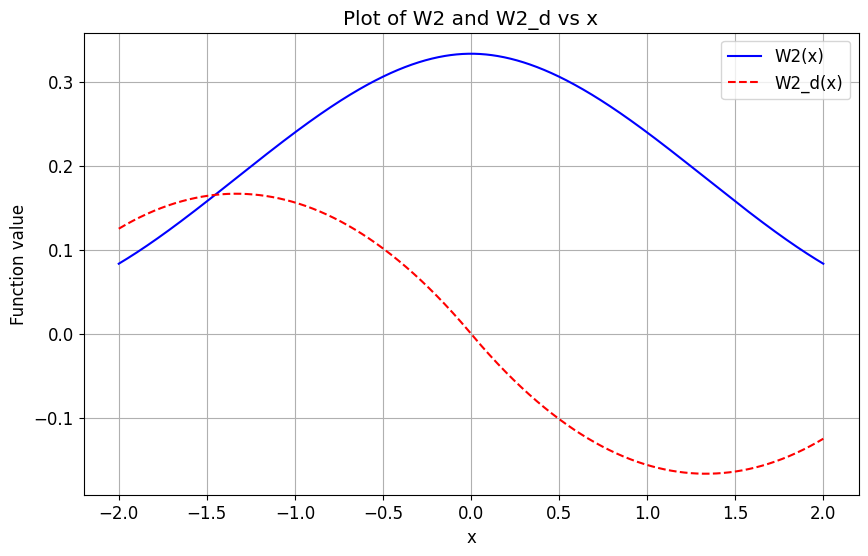

In [61]:
# Define the range of x values
x_values = np.linspace(-2, 2, 1200)

# Define a specific value for l
l = 2

# Calculate W2 and W2_d for each x value
W2_values = W2(x_values, l)
W2_d_values = kernel(x_values, l)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, W2_values, label='W2(x)', color='b')
plt.plot(x_values, W2_d_values, label='W2_d(x)', color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Function value')
plt.title('Plot of W2 and W2_d vs x')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
integral1, _ = quad(lambda x: W2(x-0,0.1), -20, 20)
print(f"The kernel is normalised and hence the integral of it over the domain should be {integral1}")

The kernel is normalised and hence the integral of it over the domain should be 0.999999999970019


In [63]:
### DEFINING CONSTANTS
T = 0.5               # Total time of integration
dt = 0.001          # Time step
N = int(T/dt)       # No of time points
a = 1               # Length of space
J = 512             # Space discretization points
P = 10               # No. of orthonarmal basis that is going to be used
d = 1.0/J
x = np.linspace(0,a,J)           # Discretization points

# Applying Initial condition
c0 = 0.25*np.sin(2*np.pi*x)                
ct = np.zeros((P,J, N+1))
for i in range(P):
    value, _ = quad_vec(lambda x:orthonormal_legendre(i)(transform(x)) * c0 * (4*x*np.exp(-0.5*(x**2)/(0.399**2))), 0, np.inf)
    ct[i, :, 0] = value

### FOR SPH

In [64]:
## defining constants
n_particles=J    ###  number of particles
dv = 1/n_particles   ### particle volume
rho0 = 1    ##### defining some random value of intial particle density
m_i = rho0*dv    ###### mass associated with each particle
c = 40/J    ###  radius/cutoff distance 
h = 1.2/J    ### smoothing length

#### creating neigbor list for particle
n_list = [ [] for i in range(n_particles) ]
x_dis = [ [] for i in range(n_particles) ]
for i in range(n_particles):
    for j in range(n_particles):
        if(i>j):
            k=-1
        else:
            k=1
        if(i!=j):
            if(np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(x[i]-x[j])
            elif(a+dv-np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(k*(a+dv-np.linalg.norm(x[i]-x[j])))
n_list=np.array(n_list)
x_dis=np.array(x_dis)

In [65]:
len(n_list[0])

78

In [66]:
### function to approximate the space derivative using SPH


def SPH(c,h,n_list=n_list):
    cd=np.zeros_like(c)
    for i,neighbors in enumerate(n_list):
        c_i = c[:, i][:, np.newaxis]  # Broadcasting to create the necessary shape
        c_i = np.repeat(c_i, len(neighbors), axis=1)
        c_j=c[:,neighbors]
        cd[:,i] = np.dot((c_i-c_j), -(kernel(x_dis[i], h))) * dv
    return cd

In [67]:
# Precompute the scalar product values values
values=np.zeros(shape=(P,P))
for i in range(P):
    for j in range(P):
        values[i,j],_=quad_vec(lambda x: u(transform(x))*orthonormal_legendre(i)(transform(x)) * orthonormal_legendre(j)(transform(x)) * (4*x*np.exp(-0.5*(x**2)/(0.399**2))), 0, np.inf)
        # if(abs(values[i,j])<1e-15):
            # values[i,j]=0

In [68]:
values

array([[ 1.91041200e-02,  3.18392660e-02, -1.56974987e-18,
         8.41332025e-18,  6.12726009e-19,  2.62943927e-18,
        -6.97770369e-20,  2.73562008e-18, -7.76001183e-19,
        -1.26643566e-17],
       [ 3.18392660e-02,  1.91041200e-02,  2.84779053e-02,
         3.83093508e-19,  2.44092085e-18, -1.46562993e-18,
         5.68373290e-18,  5.79577310e-20, -6.87411726e-18,
         1.10043001e-18],
       [-2.16606107e-18,  2.84779053e-02,  1.91041200e-02,
         2.79647478e-02,  5.62807284e-18,  5.13825674e-18,
        -2.97781865e-18, -1.15440981e-17, -1.68896568e-19,
        -5.82665887e-18],
       [ 7.32911808e-18,  1.46051942e-18,  2.79647478e-02,
         1.91041200e-02,  2.77915898e-02,  8.39657584e-19,
        -4.20492026e-18, -1.87577788e-18, -2.72187255e-18,
         5.24659689e-18],
       [ 8.41774500e-20,  2.44092085e-18,  3.81203420e-18,
         2.77915898e-02,  1.91041200e-02,  2.77125240e-02,
         9.83410418e-19, -2.58942167e-18,  2.88974590e-18,
         1.

In [69]:
### Solving using predictor-corrector scheme
for n in range(1, N+1):
    c = ct[:, :, n-1]
    cd = SPH(c, h)
    rhs = np.zeros_like(cd)
    for i in range(P):
        for j in range(P):
            rhs[i, :] += cd[j, :] * values[i, j]

    # Predictor step
    ct_pred = ct[:, :, n-1] + rhs * dt

    # Corrector step
    cd_pred = SPH(ct_pred, h)
    rhs_pred = np.zeros_like(cd_pred)
    for i in range(P):
        for j in range(P):
            rhs_pred[i, :] += cd_pred[j, :] * values[i, j]

    ct[:, :, n] = ct[:, :, n-1] + 0.5 * (rhs + rhs_pred) * dt

    print(f"Completed the {n}^th timestep")

Completed the 1^th timestep
Completed the 2^th timestep
Completed the 3^th timestep
Completed the 4^th timestep
Completed the 5^th timestep
Completed the 6^th timestep
Completed the 7^th timestep
Completed the 8^th timestep
Completed the 9^th timestep
Completed the 10^th timestep
Completed the 11^th timestep
Completed the 12^th timestep
Completed the 13^th timestep
Completed the 14^th timestep
Completed the 15^th timestep
Completed the 16^th timestep
Completed the 17^th timestep
Completed the 18^th timestep
Completed the 19^th timestep
Completed the 20^th timestep
Completed the 21^th timestep
Completed the 22^th timestep
Completed the 23^th timestep
Completed the 24^th timestep
Completed the 25^th timestep
Completed the 26^th timestep
Completed the 27^th timestep
Completed the 28^th timestep
Completed the 29^th timestep
Completed the 30^th timestep
Completed the 31^th timestep
Completed the 32^th timestep
Completed the 33^th timestep
Completed the 34^th timestep
Completed the 35^th tim

In [70]:
#### LET'S CALCULATE mean 
def calculate_mean(ct,P,x):
    f=0
    for i in range(P):
        f+=orthonormal_legendre(i)(x) * ct[i,:,:]
    return  f

value,_=quad_vec(lambda x:calculate_mean(ct,P,transform(x))*0.5* (4*x*np.exp(-0.5*(x**2)/(0.399**2))), 0, np.inf)
u_mean=value
# u_mean=ct[0,:,:]

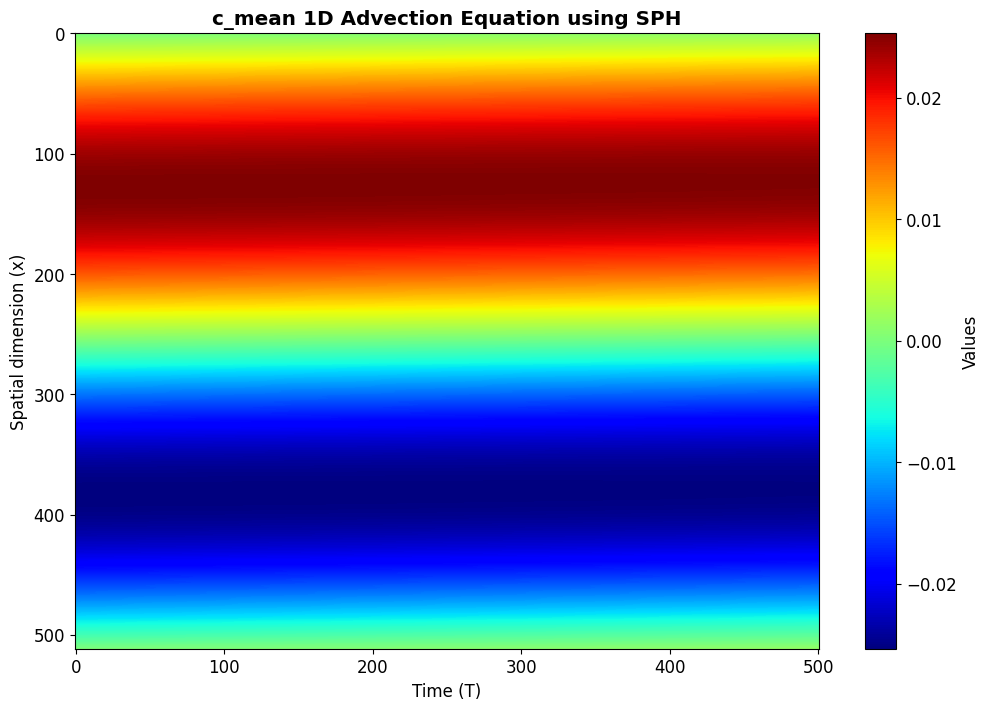

In [71]:
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig1 = plt.figure(figsize=(12,8), dpi=100)
heatmap=plt.imshow(u_mean, aspect='auto', cmap='jet')
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
plt.title('c_mean 1D Advection Equation using SPH', fontweight='bold')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')
plt.show()

In [76]:
#### LET'S CALCULATE variance
def calculate_sq(ct,P,u_mean,x):
    f=0
    # for i in range(P):
    #     f+=orthonormal_legendre(i)(x) * ct[i,:,:]
    # return  (f-u_mean)**2
    for i in range(1,P):
        f+=ct[i,:,:]**2
    return  f

# value,_=quad_vec(lambda x:calculate_sq(ct,P,u_mean,transform(x)) * 0.5 *(4*x*np.exp(-0.5*(x**2)/(0.399**2))), 0, np.inf)
# u_std=np.sqrt(value)
u_std=np.sqrt(calculate_sq(ct,P,u_mean,transform(x)))

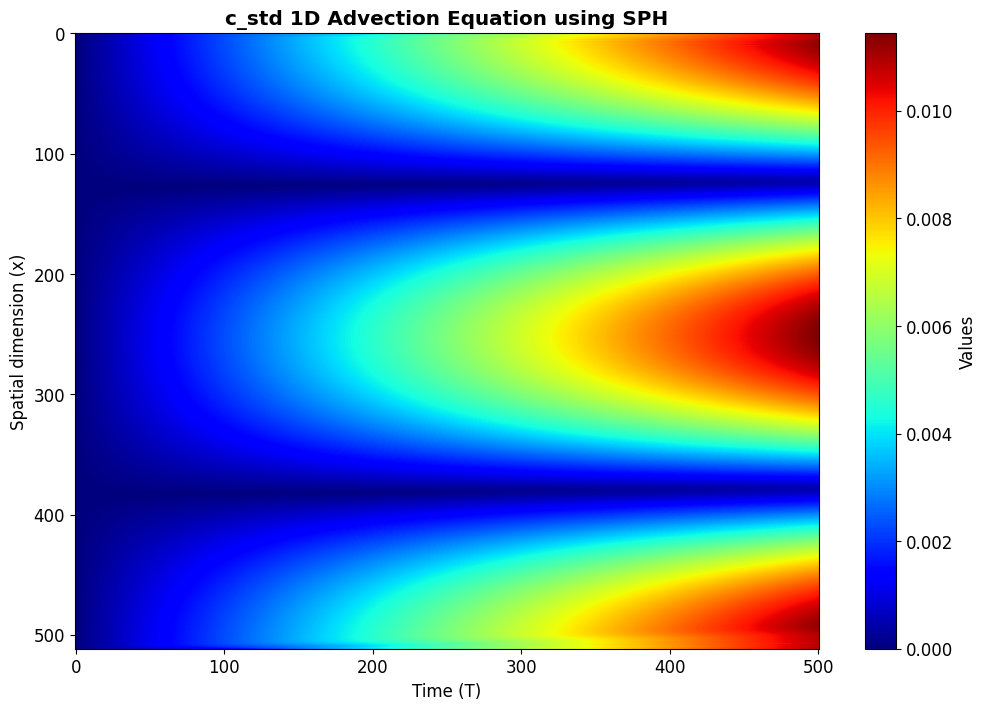

In [77]:
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig1 = plt.figure(figsize=(12,8), dpi=100)
heatmap=plt.imshow(u_std, aspect='auto', cmap='jet')
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
plt.title('c_std 1D Advection Equation using SPH', fontweight='bold')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')
plt.show()